In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1x4oWOgcpSWBtc6R5N5L6JxJInXNxstCI'})
downloaded.GetContentFile('OnlineRetail.csv')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
data = pd.read_csv('OnlineRetail.csv' ,encoding= 'unicode_escape',nrows=20000)
pd.set_option('display.max_columns', None)
data = data.dropna()
data = data.reset_index()
data.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data = data.drop(['InvoiceNo','InvoiceDate','UnitPrice','Country'], axis=1)
data.head()

,index,StockCode,Description,Quantity,CustomerID
0,0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,17850.0
1,1,71053,WHITE METAL LANTERN,6,17850.0
2,2,84406B,CREAM CUPID HEARTS COAT HANGER,8,17850.0
3,3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,17850.0
4,4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,17850.0


In [ ]:
#content-based recommendations
vectorizer = TfidfVectorizer()
vector_result = vectorizer.fit_transform(data['Description'].values)
feature_names = vectorizer.get_feature_names()

In [ ]:
vect_description = pd.DataFrame(vector_result.toarray(), columns=feature_names)
vect_description['wordbag']= vect_description.values.tolist()
data['Description'] = vect_description['wordbag']
data.head()


,index,StockCode,Description,Quantity,CustomerID
0,0,85123A,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,17850.0
1,1,71053,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,17850.0
2,2,84406B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",8,17850.0
3,3,84029G,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,17850.0
4,4,84029E,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6,17850.0


In [ ]:
def get_similar_products(Stockid, top):
    products = data[['StockCode', 'Description']]
    products  = products [products .StockCode != Stockid]
    products ['distance'] = products ['Description'].apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(data.loc[data['StockCode'] == Stockid]['Description'].values[0]).reshape(1, -1)))
    products  = products.drop(columns=['Description'])
    products  = products .explode('distance').explode('distance')
    return products.sort_values(by=['distance'], ascending=False)['StockCode'].head(top).values

In [ ]:
def get_highly_purchased(userid):
    purchase = data[data.CustomerID == user_id]
    purchase = purchase[purchase['Quantity']> 30]
    top_purchase = (purchase.sort_values(by="Quantity", ascending=False).head(20))
    top_purchase['purchased'] = top_purchase['StockCode']
    top_purchase = top_purchase[['CustomerID', 'purchased']]
    top_purchase['similar'] = top_purchase['purchased'].apply(lambda x: (get_similar_products(x, 5)))
    result = [x for x in np.concatenate(top_purchase['similar'].values, axis=0).tolist() if x not in top_purchase.purchased.values.tolist()]
    return result

In [ ]:
def get_recomended(id, top):
    similar_products = get_highly_purchased(id)
    mean_quantity = pd.DataFrame(data.groupby('StockCode')['Quantity'].mean())
    mean_quantity['rating_counts'] = pd.DataFrame(data.groupby('StockCode')['Quantity'].count())
    mean_quantity = mean_quantity[mean_quantity['rating_counts'] > 50]
    return mean_quantity[mean_quantity.index.isin(similar_products)].sort_values(by=['Quantity'], ascending=False).head(top)

In [ ]:
customer_id = data["CustomerID"].unique().tolist()
encode_user = {x: i for i, x in enumerate(customer_id)}
encoded_userid = {i: x for i, x in enumerate(customer_id)}

stock_code = data["StockCode"].unique().tolist()
encode_stock = {x: i for i, x in enumerate(stock_code)}
encoded_stockid = {i: x for i, x in enumerate(stock_code)}

data["Customer_ID"] = data["CustomerID"].map(encode_user)
data["Stock_Code"] = data["StockCode"].map(encode_stock)

num_users = len(encode_user)
num_items = len(encoded_stockid)
data["Qty"] = data["Quantity"].values.astype(np.float32)

min_rating = min(data["Quantity"])
max_rating = max(data["Quantity"])

In [ ]:
df = data.sample(frac=1, random_state=42)

x = df[["Customer_ID", "Stock_Code"]].values
y = df["Qty"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (x[:train_indices],x[train_indices:],y[:train_indices],y[train_indices:])

In [ ]:
class Recommend(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(Recommend, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(num_users,embedding_size,embeddings_initializer="he_normal",embeddings_regularizer=keras.regularizers.l2(1e-6),)
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(num_items,embedding_size,embeddings_initializer="he_normal", embeddings_regularizer=keras.regularizers.l2(1e-6),)
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        items = tf.tensordot(user_vector, item_vector, 2)
        x = items + user_bias + item_bias
        return tf.nn.sigmoid(x)

In [ ]:
model = Recommend(num_users, num_items, 50)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0005))
history = model.fit(x=x_train,y=y_train, batch_size=20, epochs=250, verbose=1, validation_data=(x_val, y_val))

Epoch 1/250
601/601 [==============================] - 2s 3ms/step - loss: 0.6850 - val_loss: 0.6449
Epoch 2/250
601/601 [==============================] - 2s 3ms/step - loss: 0.5869 - val_loss: 0.6027
Epoch 3/250
601/601 [==============================] - 2s 2ms/step - loss: 0.5534 - val_loss: 0.5896
Epoch 4/250
601/601 [==============================] - 2s 3ms/step - loss: 0.5477 - val_loss: 0.5893
Epoch 5/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5465 - val_loss: 0.5881
Epoch 6/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5463 - val_loss: 0.5867
Epoch 7/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5460 - val_loss: 0.5870
Epoch 8/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5459 - val_loss: 0.5849
Epoch 9/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5458 - val_loss: 0.5825
Epoch 10/250
601/601 [==============================] - 1s 2ms/step - loss: 0.5461 - val_lo

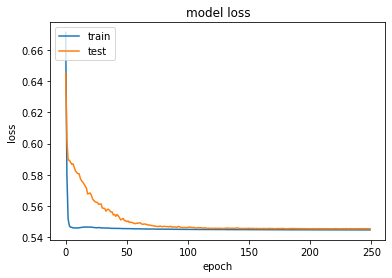

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
user_id = int(input()) 
#Hint : Available Customer IDs : 13047 , 12583 , 15291 , 14688 , 15311

12583


In [ ]:
top_purchased = get_recomended(user_id, 5)
content= top_purchased .index.values.tolist()

In [ ]:
#Collaborative filtering
ds_new = pd.read_csv('OnlineRetail.csv' ,encoding= 'unicode_escape',nrows=20000)

purchased_items = df[df.CustomerID== user_id]
not_purchased = data[~ds_new["StockCode"].isin(purchased_items.StockCode.values)]["StockCode"]
not_purchased = list(set(not_purchased).intersection(set(encode_stock.keys())))
not_purchased = [[encode_stock.get(x)] for x in not_purchased]

user_encoder = encode_user.get(user_id)
user_items = np.hstack(([[user_encoder]] * len(not_purchased), not_purchased))

quantities = model.predict(user_items).flatten()
top_purchased = quantities.argsort()[-20:][::-1]

recommended_stockid = [encoded_stockid.get(not_purchased[x][0]) for x in top_purchased]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [ ]:
print("RECOMMENDED PRODUCTS | CUSTOMER ID :",user_id, "\n")

recommending = random.sample((recommended_stockid), 10)
recommended_products = ds_new[ds_new["StockCode"].isin(recommending)]
recomended_item_list = []
for row in recommended_products.itertuples():
    recomended_item_list .append(row.Description)
unique_numbers = list(set(recomended_item_list ))
print(*unique_numbers, sep = "\n")

RECOMMENDED PRODUCTS | CUSTOMER ID : 12583 

TOY TIDY PINK POLKADOT
CD WALL TIDY RED FLOWERS
VICTORIAN GLASS HANGING T-LIGHT
WOODEN BOX ADVENT CALENDAR 
SET OF 36 PAISLEY FLOWER DOILIES
VINTAGE RED KITCHEN CABINET
COOKING SET RETROSPOT
NAMASTE SWAGAT INCENSE
SMALL POLKADOT CHOCOLATE GIFT BAG 
WORLD WAR 2 GLIDERS ASSTD DESIGNS
